# Monsoon Model
### Modified Zickfeld model, Saha 2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
%load_ext autoreload
%autoreload 2

### Model Inputs / boundary conditions

1. Temperature, T_side(day)
2. Sp. humidity, q_side(day)
3. Wind, u_side(day)
4. Insolation, insol(day) <-- prescribed as a function of lat

## Functions to Read Inputs

In [122]:
def read_inputs(label):

    input_path = '_inputFiles/' + label + '/input_'

    input_file_T_N = input_path + 'T_N.dat'
    input_file_T_E = input_path + 'T_E.dat'
    input_file_T_S = input_path + 'T_S.dat'
    input_file_T_W = input_path + 'T_W.dat'

    input_file_qs_N = input_path + 'qs_N.dat'
    input_file_qs_E = input_path + 'qs_E.dat'
    input_file_qs_S = input_path + 'qs_S.dat'
    input_file_qs_W = input_path + 'qs_W.dat'

    input_file_u_N = input_path + 'u_N.dat'
    input_file_u_E = input_path + 'u_E.dat'
    input_file_u_S = input_path + 'u_S.dat'
    input_file_u_W = input_path + 'u_W.dat'

    # get number of lines in one file
    # (they should all be the same)
    Ndays = 0
    with open(input_file_T_N, 'r') as f:
        for line in f:
            Ndays += 1

    T_side = np.zeros((Ndays, 4))
    qs_side = np.zeros((Ndays, 4))
    u_side = np.zeros((Ndays, 4))

    T_side[:,0] = np.loadtxt(fname = input_file_T_N)
    T_side[:,1] = np.loadtxt(fname = input_file_T_E)
    T_side[:,2] = np.loadtxt(fname = input_file_T_S)
    T_side[:,3] = np.loadtxt(fname = input_file_T_W)

    qs_side[:,0] = np.loadtxt(fname = input_file_qs_N)
    qs_side[:,1] = np.loadtxt(fname = input_file_qs_E)
    qs_side[:,2] = np.loadtxt(fname = input_file_qs_S)
    qs_side[:,3] = np.loadtxt(fname = input_file_qs_W)

    u_side[:,0] = np.loadtxt(fname = input_file_u_N)
    u_side[:,1] = np.loadtxt(fname = input_file_u_E)
    u_side[:,2] = np.loadtxt(fname = input_file_u_S)
    u_side[:,3] = np.loadtxt(fname = input_file_u_W)

    # Flip sign of N and E Wind inputs    
    u_side[:,0] = -u_side[:,0]
    u_side[:,1] = -u_side[:,1]
    
    # read insoaltion
    # should be specific to the center of each box. currently there is only one insolation input file
    input_file_insol = input_path + 'insol.dat'

    # insol = np.zeros((1827, 1))

    insol = np.loadtxt(fname = input_file_insol)
    
    return T_side, qs_side, u_side, insol


## Functions

In [105]:
def Tz(z, Ta, qa, Ncu):
    return (Ta - (gamma0 + gamma1*(Ta-T0)*(1-aq*qa**2) - gamma2*Ncu)*z)

def qz(z, qa):
    return (qa*np.exp(-z/He))

def rho(z):
    return (rho0*np.exp(-z/H0))

def p(z):
    return (p0*np.exp(-z/H0))

def qsat(z, Ta, qa, Ncu):
    return (qsat0*(p0/p(z))*np.exp(-((0.622*L/R)*(1/Tz(z,Ta,qa,Ncu)-1/T0))))

### Run-time Functions

In [106]:
def u_vert(t_day):
    
    return width * integrate.quad(rho,0,H_mon)[0] * np.sum(u_side[t_day,:])/(A_g*rho(np.mean([H_Had, H_mon])))

In [107]:
def adv_heat_side(i, t_day, Ta, qa, u0_p, u1_p, u0_m, u1_m, Ncu):
    
    return (Cair * width * ( \
                            + integrate.quad(lambda z: u0_p[i]*rho(z)*Tz(z, T_side[t_day,i], qa, Ncu), 0, H_mon  )[0] \
                            - integrate.quad(lambda z: u1_p[i]*rho(z)*Tz(z, Ta, qa, Ncu), H_mon, H_trop)[0] \
                            - integrate.quad(lambda z: u0_m[i]*rho(z)*Tz(z, Ta, qa, Ncu), 0, H_mon  )[0] \
                            + integrate.quad(lambda z: u1_m[i]*rho(z)*Tz(z, T_side[t_day,i], qa, Ncu), H_mon, H_trop)[0] \
                          ))

In [108]:
def adv_q_side(i, t_day, Ta, qa, u0_p, u1_p, u0_m, u1_m, Ncu):
    
    return (width * ( \
                            + integrate.quad(lambda z: u0_p[i]*rho(z)*qz(z, qs_side[t_day,i]), 0, H_mon  )[0] \
                            - integrate.quad(lambda z: u1_p[i]*rho(z)*qz(z, qa), H_mon, H_trop)[0] \
                            - integrate.quad(lambda z: u0_m[i]*rho(z)*qz(z, qa), 0, H_mon  )[0] \
                            + integrate.quad(lambda z: u1_m[i]*rho(z)*qz(z, qs_side[t_day,i]), H_mon, H_trop)[0] \
                          ))

In [109]:
def clouds(v, qa, Ta):
    
    # ========================================== CLOUD COVERAGE AND ALBEDOS
    # ------------------------------------------------------ cumulus clouds
    if (v>0):    # upward velocity
        Ncu = Ncu0 * np.tanh(v/a1cu) * np.tanh(qa/a2cu)
    else: # downward velocity
        Ncu = 0 

    # ------------------------------------------------------ stratus clouds
    Nst   = (qa/qsat(0,Ta,qa,Ncu))**(1.5) * (a1st+a2st*(1+np.tanh(v/a3st)))

    # --------------------------------------------------------- total cloud
    N    = 1 - (1-Ncu)*(1-Nst)

    # --------------------------------------------------------- clear sky
    Ncs  = 1 - N
    
    return Ncu, Nst, N, Ncs

### Solving Routine using Euler's Scheme

In [110]:
# Euler's scheme to solve the monsoon ODEs

def solve_monsoon_ODEs_euler(Ta, qa, w, w2, T_side, qs_side, u_side, insol):
    
    Ta_arr       = []
    qa_arr       = []
    w_arr        = []
    P_mmpday_arr = []

    ## //////////////////////////////////////////////////////////// TIME LOOP
    ## //////////////////////////////////////////////////////////////////////
    t = dt

    while (t<dur_sim):

        # current time
        t_day         = int(np.floor(t/sec_day))
        t_months      = int(np.floor(t/sec_month))
        t_day_of_year = int(np.remainder(np.ceil(t/sec_day),365)+1)

        # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< READ INPUT VARIABLES 
        # INPUTS: Temperature, Sp Hum, Wind, and Insolation


#         # Wind inputs    
#         u_side[t_day,0] = -u_side[t_day,0]
#         u_side[t_day,1] = -u_side[t_day,1]


        # Insolation input [W m^-2]
        Iin           = insol[t_day_of_year]

        # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        # --------------------------------------------------- vertical velocity 
        v             = u_vert(t_day)

        # --------------------------------------------------- clouds
        Ncu, Nst, N, Ncs = clouds(v, qa, Ta)

        # Ncudot
        if (t<=dt):
            Ncudot = 0
        else:
            Ncudot = -(Ncu_old - Ncu)/dt


        # -------------------------------------------------------------- albedo
        # (clouds have specified albedos)


        alpha = Nst*alphast + Ncu*alphacu + Ncs*alphacs


        # ======================= FLUXES DUE TO MONSOON, HADLEY AND TRADE WINDS
        # (height change of N side due to Tibet not included)

        # ------------------------------------------------------------- monsoon 
        # (positive values imply box-ward flow)

        # u0 = surface wind
        # u1 = top wind

        # UP/DOWN-STREAM flows
        u0_p = (1/2)*(abs(u_side[t_day,:]) + u_side[t_day,:])
        u0_m = (1/2)*(abs(u_side[t_day,:]) - u_side[t_day,:])
        u1_p = k_u_mon * u0_p
        u1_m = k_u_mon * u0_m

        # heat advection, summed from all sides
        adv_heat = sum(adv_heat_side(i, t_day, Ta, qa, u0_p, u1_p, u0_m, u1_m, Ncu) for i in range(0, 4)) 

        # moisture advection, summed from all sides
        adv_q    = sum(adv_q_side(i, t_day, Ta, qa, u0_p, u1_p, u0_m, u1_m, Ncu) for i in range(0, 4)) 


        # ================================================= CONDENSATION HEIGHT
        # From the intersection of dew point and dry lapse rates
        # qaREL = 0.263*p0*qa*(exp(17.67*(Ta-T0)/(Ta-29.65)))^(-1)

        qaREL = qa/qsat(0, Ta, qa, Ncu)
        Tadew = Ta - (100-qaREL)/5

        H_c   = max((Ta-Tadew)/(Gamma_a - Gamma_dew),0)

        # ======================================================= PRECIPITATION
        if (H_c<H_trop and H_c>=0):
            # Zickfeld
            P = max((N/tau_p) * integrate.quad(lambda z: (rho(z)*qz(z,qa)), H_c, H_trop)[0], 0)
            #      P = max((N/tau_p) * quad(@(z) (rho(z).*qz(z,qa)), 0, H_trop),0)
        else:
            P = 0

        # ========================================================= EVAPORATION
        # (from ground only, only positive)
        # total surface wind:
        # usfc = abs(sum(u_side))

        usfc = np.sqrt((u_side[t_day,:][0]+u_side[t_day,:][2])**2 + (u_side[t_day,:][1]+u_side[t_day,:][3])**2)

        E  = max(k_e * w * usfc * rho0 * (qsat(0,Ta,qa,Ncu)-qa), 0)

        # =========================================================== RADIATION
        Iout  = B0 + B1*(Ta-T0) - N*(B2 + B3*(Ta-T0))

        # ================================================= GOVERNING EQUATIONS
        # MOISTURE EQ
        qdot_L      = (E-P)/(((1-np.exp((-2*H_trop)/H0))*H0*rho0)/2)
        qdot_adv    = (adv_q/A_g)/(((1-np.exp((-2*H_trop)/H0))*H0*rho0)/2)

        qadot       = qdot_L + qdot_adv

        # HEAT EQ
        RHS_HEATEQ  = A_g * (Iin*(1 - alpha) - Iout + L*(P - E)) + adv_heat

        Tadot       = (Cg*np.exp(1)**(H0**(-1)*H_trop)*m_g+A_g*Cair*H0*((-1)+(-1)* \
            gamma1*(H0+H_trop)*((-1)+aq*qa**2)+np.exp(1)**(H0**(-1)*H_trop)*( \
            1+gamma1*H0*((-1)+aq*qa**2)))*rho0)**(-1)*(np.exp(1)**(H0**(-1) \
            *H_trop)*RHS_HEATEQ+(-1)*A_g*Cair*H0*(((-1)+np.exp(1)**(H0**(-1)*H_trop) \
            )*H0+(-1)*H_trop)*rho0*(gamma2*Ncudot+2*aq*gamma1*qa*qadot* \
            ((-1)*T0+Ta)))

        # GROUND WATER EQ
        Roff  = k_Roff * P * w

        # wdot  = ((P - E - Roff)/f1) - (w-w2)/tau_w
        wdot  = ((P - E - Roff)/f1)
        # w2dot = (f1/f2) * (w-w2)/tau_w
        w2dot = 0

        # put these in a function and return some diagnostic variables.
        # =================================================== EULER INTEGRATION
        Ta = Ta + Tadot*dt
        qa = min(max(qa + qadot*dt, 1e-10),1)
        w  = min(max(w + wdot*dt, 0),1)
        w2 = min(max(w2 + w2dot*dt,0),1)

        # ============================================================== OUTPUT
        if (np.remainder(t, sec_day)==0): ## write values once every day      
            P_mmpday = P * sec_day
            E_mmpday = E * sec_day

            P_mmpday_arr.append(P_mmpday)
            Ta_arr.append(Ta)
            qa_arr.append(qa)
            w_arr.append(w)

            # 1    2   3   4  5  6    7         8         9                     10 11
            # t_day, Ta, qa, w, v, H_c, E_mmpday, P_mmpday, qsat(0,Ta,qa,Ncu)-qa, N, Ncu)


        if (np.remainder(t,sec_month)==0):
             print ('month: ', t/sec_month)

        # ====================================================== TIME INCREMENT
        t = t + dt
        Ncu_old = Ncu
    ## //////////////////////////////////////////////////////// END TIME LOOP
    ## /////////////////////////////////////////////////////////////////////



    Ta_arr = np.array(Ta_arr)
    qa_arr = np.array(qa_arr)
    w_arr  = np.array(w_arr)
    P_mmpday_arr = np.array(P_mmpday_arr)

    return Ta_arr, qa_arr, w_arr, P_mmpday_arr


## Plotting Routine

In [111]:
def plot_arrays(Ta_arr, qa_arr, w_arr, P_mmpday_arr):

    fig, axs = plt.subplots(2,2, figsize = (12,6))
    
    axs[0, 0].step(Ta_arr, 'k')
    axs[0, 0].step(T_side[0:len(Ta_arr), 0], 'red', alpha=0.5)
    axs[0, 0].step(T_side[0:len(Ta_arr), 1], 'red', alpha=0.5)
    axs[0, 0].step(T_side[0:len(Ta_arr), 2], 'red', alpha=0.5)
    axs[0, 0].step(T_side[0:len(Ta_arr), 3], 'red', alpha=0.5)
    axs[0, 0].set_title('Temperature')
    axs[0, 0].set(ylabel = 'K')

    axs[0, 1].step(qa_arr, 'purple')
    axs[0, 1].step(qs_side[0:len(Ta_arr), 0], 'red', alpha=0.5)
    axs[0, 1].step(qs_side[0:len(Ta_arr), 1], 'red', alpha=0.5)
    axs[0, 1].step(qs_side[0:len(Ta_arr), 2], 'red', alpha=0.5)
    axs[0, 1].step(qs_side[0:len(Ta_arr), 3], 'red', alpha=0.5)
    axs[0, 1].set_title('Specific Humidity')
    axs[0, 1].set(ylabel = '')
    
    axs[1, 0].step(w_arr, 'g')
    axs[1, 0].set_title('Ground Moisture')
    axs[1, 0].set(ylabel = '')

    axs[1, 1].step(P_mmpday_arr[1:], '-')
    axs[1, 1].set_title('Precipitation ')
    axs[1, 1].set(ylabel = '[mm/day]')

    for ax in axs.flat:
        ax.set(xlabel='Days')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        
    # Output 
    output_path = '_outputs/' + label
    output_plotfile = output_path + '/out_plot.pdf'
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    plt.savefig(output_plotfile)  

### Main Program

simulation length =  1  yr
time step =  1  days

-------------------------------
running sim over box  INAS 

sim progress ...
month:  1 / 12
month:  2 / 12
month:  3 / 12
month:  4 / 12
month:  5 / 12
month:  6 / 12
month:  7 / 12
month:  8 / 12
month:  9 / 12
month:  10 / 12
month:  11 / 12
month:  12 / 12

done


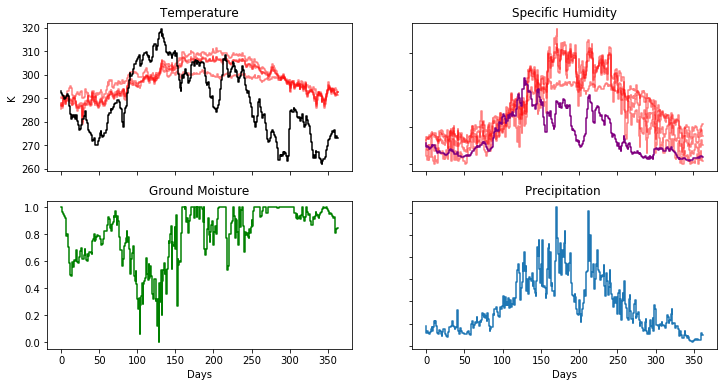

In [127]:
# IMPORT MODEL FUNCTIONS
# .......................................................................
# model parameters called from within the function file
import monsoon_RS17 as monRS17


# .......................................................................
# READ INPUTS
# .......................................................................
label = 'INAS'
T_side, qs_side, u_side, insol = monRS17.read_inputs(label)


# .......................................................................
## DEFINE INITIAL CONDITIONS
# .......................................................................
Ta = Ts
qa = 0.015
w  = 0.35        # soil moisture content [kg m^-2]
w2 = 0           # soil moisture content [kg m^-2]


print ('simulation length = ', dur_sim_yr, ' yr')
print ('time step = ', dt_day, ' days\n')
print ('-------------------------------')
print ('running sim over box ', label, '\n')

print ('sim progress ...')

# .......................................................................
## CALL SYSTEM SOLVER
# .......................................................................
Ta_arr, qa_arr, w_arr, P_mmpday_arr = monRS17.solve_monsoon_ODEs_euler(Ta, qa, w, w2, T_side, qs_side, u_side, insol)

print ('\ndone')

# .......................................................................
## PLOT ARRAYS
monRS17.plot_arrays(Ta_arr, qa_arr, w_arr, P_mmpday_arr, T_side, qs_side, u_side)



simulation length =  1  yr
time step =  1  days

-------------------------------
running sim over box  INBMY 

sim progress ...
month:  1 / 12
month:  2 / 12
month:  3 / 12
month:  4 / 12
month:  5 / 12
month:  6 / 12
month:  7 / 12
month:  8 / 12
month:  9 / 12
month:  10 / 12
month:  11 / 12
month:  12 / 12

done
Model outputs below
Plot lines in red show input values at the boundaries


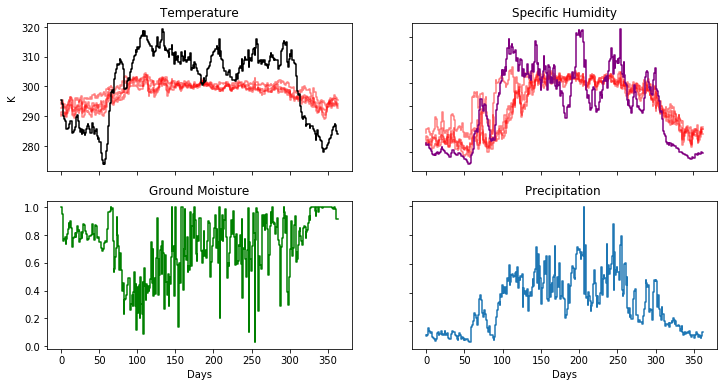

In [6]:
%run -i 'main.py'

In [2]:
width

889419.7868163104

In [5]:
Ta_arr

array([295.44665593, 295.30493989, 293.99318874, 290.99364476,
       290.05139523, 289.02920041, 288.42559968, 286.2483278 ,
       285.65077748, 285.78756441, 286.19453784, 286.78720514,
       287.34072783, 288.38452505, 288.55703515, 286.0935377 ,
       284.32218242, 284.79784851, 285.35909676, 286.35688905,
       287.83961411, 289.6701526 , 290.30508142, 288.55234941,
       287.95143473, 285.89645049, 284.75086694, 285.71417199,
       283.98457835, 284.38805297, 285.32797856, 284.43925353,
       283.53901223, 284.34459863, 285.77844622, 286.84053664,
       287.55157983, 286.57398938, 285.84949569, 284.28628585,
       284.52696133, 286.03865059, 287.61451562, 286.24571012,
       284.16235929, 284.20709331, 285.12137506, 285.7288753 ,
       283.42533127, 282.24553556, 282.60868731, 281.21493145,
       281.27708594, 279.46552112, 277.69638949, 275.33443119,
       273.90843047, 274.189999  , 274.09093106, 275.76663764,
       278.40458441, 280.83877966, 283.17218514, 286.84